# Plotting

In [12]:
import os 
from tqdm import tqdm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank 
import librosa

In [47]:
args={'src_root':'wavfiles_for_cleaning',
      'dst_root':'cleanwavs',
     'delta_time':1.0,
     'sr':16000,
     'threshold':'20',
      'fn':'3a3d0279'
     }

In [13]:
#signal (Amplitude, time(s))
def plot_signals (signals):
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i=0
    for x in range(2):
            for y in range(1):
                axes[x,y].set_title(list(signals.keys())[i])
                axes[x,y].plot(list(signals. values())[i]) 
                axes [x,y].get_xaxis().set_visible(False)
                axes [x,y].get_yaxis().set_visible(False)
                i += 1

In [14]:
def plot_mfccs(mfccs): 
    fig, axes = plt.subplots (nrows=2, ncols=2, sharex=False, sharey=True, figsize=(28,5)) 
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16) 
    i=0 
    for x in range(2): 
        for y in range(1): 
            axes[x,y].set_title(list(mfccs.keys())[i]) 
            axes [x,y].imshow(list (mfccs.values())[i], cmap='hot', interpolation='nearest') 
            axes[x,y].get_xaxis().set_visible(False) 
            axes[x,y].get_yaxis().set_visible(False) 
            i += 1

In [15]:
def plot_fft(fft): 
    fig, axes = plt.subplots (nrows=2, ncols=2, sharex=False, sharey=True, figsize=(20,5)) 
    fig.suptitle('Fourier Transforms', size=16) 
    i=0 
    for x in range(2): 
        for y in range(1): 
            data= list(fft.values())[i] 
            Y, freq = data[0], data[1] 
            axes [x,y].set_title(list(fft.keys())[i]) 
            axes[x,y].plot(freq, Y) 
            axes[x,y].get_xaxis().set_visible(False) 
            axes [x,y].get_yaxis().set_visible(False) 
            i += 1

In [16]:
def plot_fbank(fbank): 
    fig, axes = plt.subplots (nrows=2, ncols=2, sharex=False, sharey=True, figsize=(28,5)) 
    fig.suptitle('Filter Bank Coefficients', size=16) 
    i=0 
    for x in range(2): 
        for y in range(1): 
            axes [x,y].set_title(list (fbank.keys())[i]) 
            axes [x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation="nearest") 
            axes [x,y].get_xaxis().set_visible(False) 
            axes [x,y].get_yaxis().set_visible(False) 
            i += 1

In [17]:
from tensorflow.keras.models import load_model
from clean2 import downsample_mono, envelope, downsample_mono_v2
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio



In [18]:
path_to_folder = os.getcwd()
path_to_voice = '\\samples2\\both'
path_to_plane = '\\samples2\\plane'

# Loading Data

In [19]:
import csv

prplot="C:/Users/HAMZA/Audio-Classification/prplot.csv"

valeurs = []
entetes = [
     "fname",
     "label"
]

for i in range(150):
    if (i<62):
        valeurs.append([u'sample_p_'+str(i)+'.wav',u'Plane'])
    elif (i<93 and i>=62):
        valeurs.append([u'sample_b_'+str(i%62)+'.wav',u'Both'])

with open(prplot, "w",newline="") as csv_file:
    writer = csv.writer(csv_file, delimiter = ",")
    writer.writerow(entetes)
    for i in range (93):
        writer.writerow(valeurs[i])
        
df = pd.read_csv('prplot.csv') 
df.set_index('fname', inplace=True) 





# enregistrement des samples

In [43]:
def save_spl(sample, rate, target_dir, fn, ix):
    fn = fn.split('.wav')[0]
    dst_path = os.path.join(target_dir.split(
        '.')[0], fn+'_{}.wav'.format(str(ix)))
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)

# Decoupage de l'audio

In [44]:
def split_wavs(args):
    src_root = args['src_root']
    dst_root = args['dst_root']
    dt = args['delta_time']

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x for x in wav_paths if '.wav' in x]
    dirs = os.listdir(src_root)
    check_dir(dst_root)
    classes = os.listdir(src_root)
    for _cls in classes:
        target_dir = os.path.join(dst_root, _cls)
        check_dir(target_dir)
        src_dir = os.path.join(src_root, _cls)
        for fn in tqdm(os.listdir(src_dir)):
            src_fn = os.path.join(src_dir, fn)
            rate, wav = downsample_mono(src_fn, args['sr'])
            mask, y_mean = envelope(wav, rate, threshold=args['threshold'])
            wav = wav[mask]
            delta_sample = int(dt*rate)

            # l'audio nettoyé est inférieur à un seul échantillon
            # remplir avec des zéros à la taille delta_sample
            if wav.shape[0] < delta_sample:
                sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
                sample[:wav.shape[0]] = wav
                save_spl(sample, rate, target_dir, fn, 0)

            # parcourir l'audio et enregistrer chaque delta_sample
            # enlever la fin des audio si c'est plus court
            else:
                trunc = wav.shape[0] % delta_sample
                for cnt, i in enumerate(np.arange(0, wav.shape[0]-trunc, delta_sample)):
                    start = int(i)
                    stop = int(i + delta_sample)
                    sample = wav[start:stop]
                    save_spl(sample, rate, target_dir, fn, cnt)

In [45]:
def check_dir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)

# fcts of Cleanning and Treatment

In [20]:
def wav_16k_mono(path):
    # Load encoded wav file
    load_file = tf.io.read_file(path)
    # décoder en mono channel
    wav, sr = tf.audio.decode_wav(load_file, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype=tf.int64)
    # en 16KHZ
    wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
    return wav

In [40]:
def downsample_mono_v2(path, sr):
    wavs = []
    obj = wavio.read(path)
    wav1 = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    #print(wav1.shape[0])
    # nouveaux audio de 03s
    for i in range(0, len(wav1), rate*3):
        #print("mono_v2 " + str(i))
        wav = []
        for j in range(len(wav1)-i):
            wav.append(wav1[i+j])
        wav = np.array(wav, dtype=np.float32)
        try:
            channel = wav.shape[1]
            if channel == 2:
                wav = to_mono(wav.T)
            elif channel == 1:
                wav = to_mono(wav.reshape(-1))
        except IndexError:
            wav = to_mono(wav.reshape(-1))
            pass
        except Exception as exc:
            raise exc
        wav = resample(wav, rate, sr)
        wav = wav.astype(np.int16)
        wavs.append(wav)
    return sr, wavs

In [21]:
path = path_to_folder + path_to_voice + "\\" + 'voix+plan).wav'

In [22]:
load_file = tf.io.read_file(path)

In [23]:
wav, sr = tf.audio.decode_wav(load_file, desired_channels=1)

In [24]:
#1 car mono
wav

<tf.Tensor: shape=(34427577, 1), dtype=float32, numpy=
array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       ...,
       [-9.1552734e-05],
       [ 6.1035156e-05],
       [-6.1035156e-05]], dtype=float32)>

In [25]:
len(wav)

34427577

In [26]:
wav = tf.squeeze(wav, axis=-1)
sr = tf.cast(sr, dtype=tf.int64)

In [27]:
wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

In [28]:
len(wav)

11475859

In [29]:
def enveloppe_max(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20), min_periods=1,center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [30]:
def enveloppe_mean(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20), min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [31]:
def calc_fft(y, rate): 
    n = len(y) 
    freq = np.fft.rfftfreq(n, d=1/rate) # d: distance entre nos samples
    Y = abs(np.fft.rfft(y)/n) #MAGNITUDE
    return (Y, freq)

In [32]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [33]:
df

,label
fname,
sample_p_0.wav,Plane
sample_p_1.wav,Plane
sample_p_2.wav,Plane
sample_p_3.wav,Plane
sample_p_4.wav,Plane
...,...
sample_b_26.wav,Both
sample_b_27.wav,Both
sample_b_28.wav,Both


In [34]:
df.reset_index(inplace=True) 
classes = list(np. unique (df.label))#unicité de chaque classe
for c in classes: 
    rate = 16000
    wav_16k_mono(path)
    wav_file_plot = df[df.label == c].iloc[0,0]
    #signal = wav_16k_mono('wavfiles1/{}/'.format(c.lower())+ wav_file_plot)
    signal, rate = librosa.load('wavfiles1/{}/'.format(c.lower())+wav_file_plot, sr=44100)
    mask = enveloppe_max(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft (signal, rate)
    
    bank = logfbank (signal[:rate], rate, nfilt=26, nfft=1103).T #nfft: window length
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1183).T# numcep: numcep qu on laisse après discret cosine transoform on filter bank energies
    mfccs[c] = mel

In [35]:
df

,fname,label
0,sample_p_0.wav,Plane
1,sample_p_1.wav,Plane
2,sample_p_2.wav,Plane
3,sample_p_3.wav,Plane
4,sample_p_4.wav,Plane
...,...,...
88,sample_b_26.wav,Both
89,sample_b_27.wav,Both
90,sample_b_28.wav,Both
91,sample_b_29.wav,Both


# Comparaison Avant et Après ajout de voix au même vocal

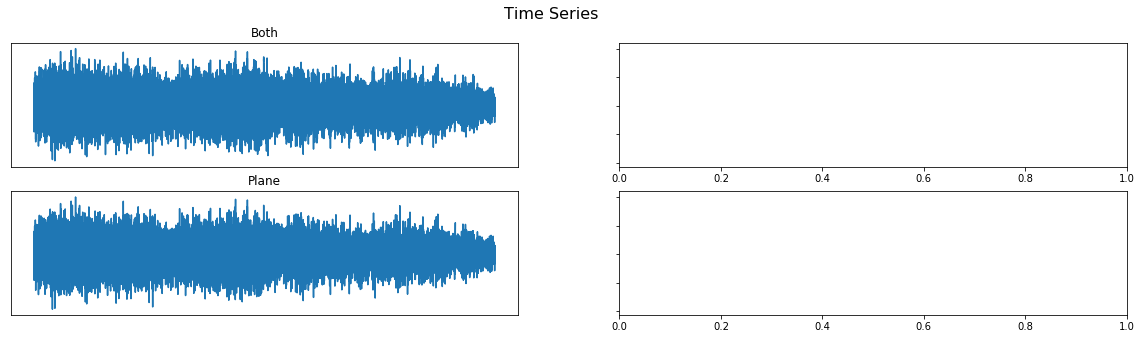

In [36]:
plot_signals(signals)
plt.show()

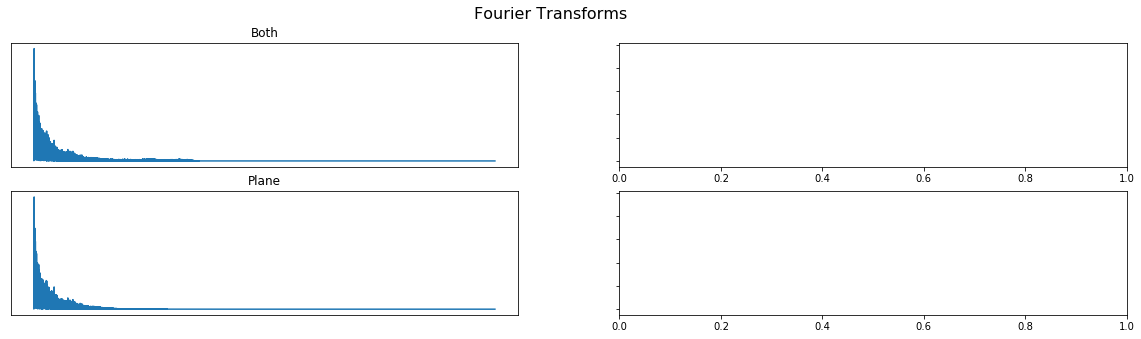

In [37]:
plot_fft(fft)
plt.show()


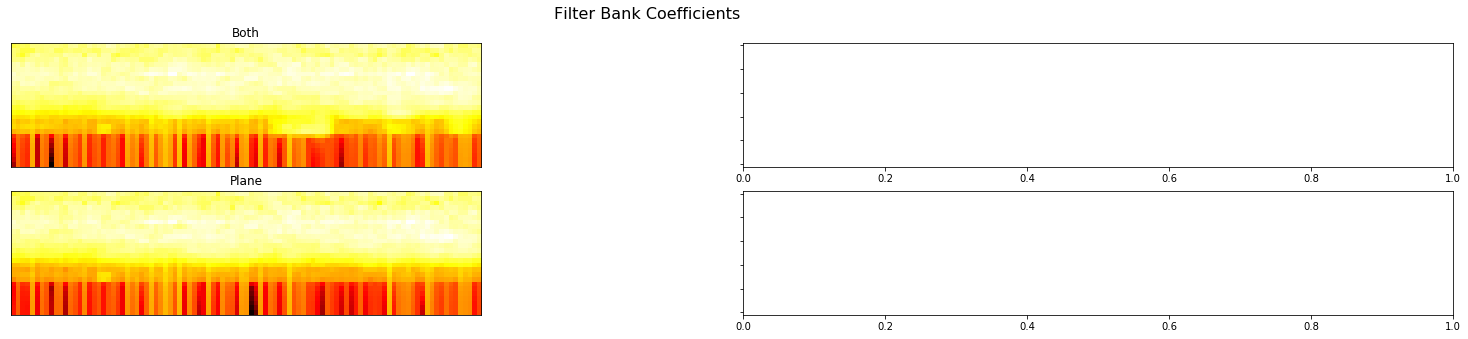

In [38]:
plot_fbank(fbank)
plt.show() 

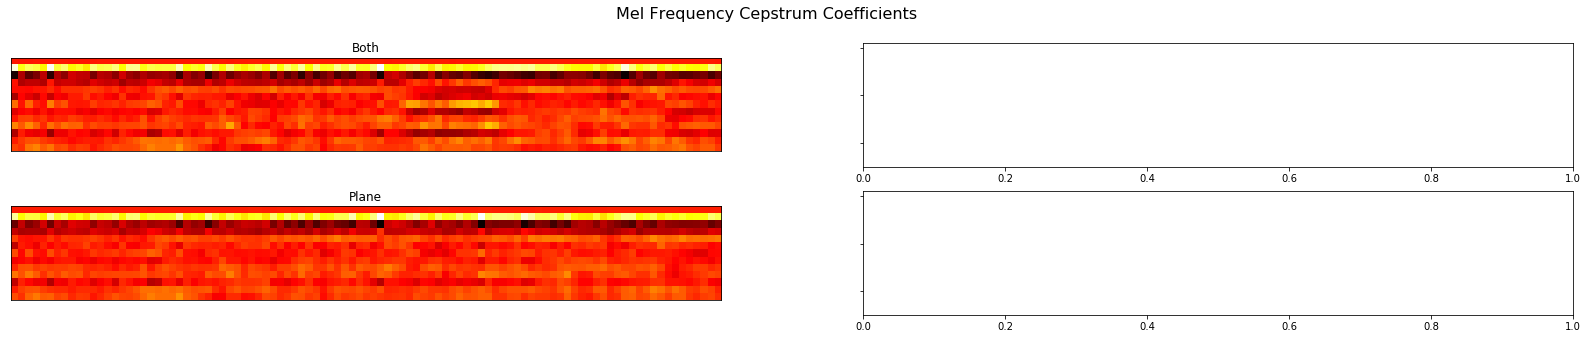

In [39]:
plot_mfccs(mfccs) 
plt.show()

# cleanning

In [48]:
split_wavs(args)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.31it/s]
